### Image Classification using Keras Hub - Intermediate Level

This notebook demonstrates an intermediate-level image classification task using the TensorFlow Flowers dataset.  



In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # Ensure Keras 3 uses JAX backend


In [ ]:
import keras
import keras_hub
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Load and preprocess the Flowers dataset  
This cell downloads the TensorFlow Flowers dataset and prepares training and validation splits.  
Images are resized and normalized to prepare them for model input.


In [ ]:
dataset_name = "tf_flowers"
dataset, dataset_info = tfds.load(
    dataset_name,
    as_supervised=True,
    with_info=True
)
data_train, data_test = dataset["train"].take(2000), dataset["train"].skip(2000).take(1000)  # Faster training with a smaller dataset




Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.L1PQH9_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = dataset_info.features['label'].num_classes

def preprocess_inputs(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


In [ ]:
# Preprocess dataset
data_train = data_train.map(preprocess_inputs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
data_test = data_test.map(preprocess_inputs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load EfficientNetB0 model using keras.applications
base_model = keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Build the model using a pretrained Keras backbone  
A lightweight pretrained model is loaded from Keras Applications (e.g. MobileNet or similar).  
Custom classification layers are added for the specific number of flower classes.


In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)  # Ensure proper shape before Dense layers
x = keras.layers.Dense(128, activation="relu")(x)  # Reduced layer size for speed
x = keras.layers.Dropout(0.3)(x)  # Lower dropout for speed
x = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, x)

### Compile the model  
The model is compiled with the Adam optimizer and categorical crossentropy loss.  
Accuracy is used as the evaluation metric during training.


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Train the model
history = model.fit(data_train, validation_data=data_test, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.2233 - loss: 1.9027 - val_accuracy: 0.2260 - val_loss: 1.6039
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 325ms/step - accuracy: 0.2231 - loss: 1.6052 - val_accuracy: 0.2660 - val_loss: 1.6019
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.2486 - loss: 1.6039 - val_accuracy: 0.2660 - val_loss: 1.5966
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.2486 - loss: 1.6031 - val_accuracy: 0.2660 - val_loss: 1.5959
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.2486 - loss: 1.6003 - val_accuracy: 0.2660 - val_loss: 1.5934


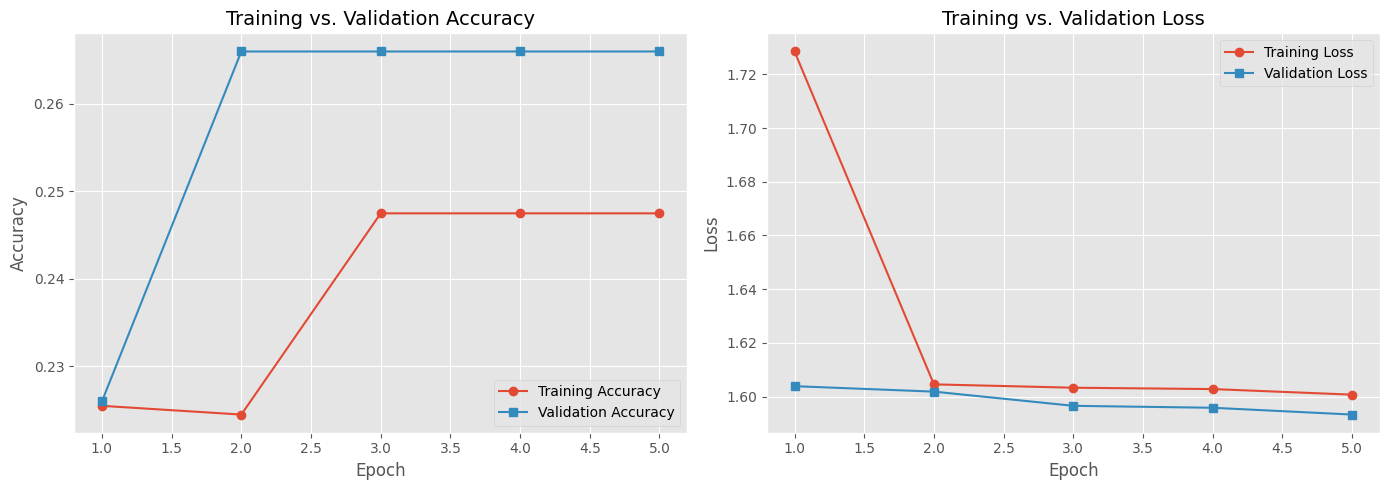

In [ ]:
import matplotlib.pyplot as plt

def plot_intermediate_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(1, len(acc) + 1)

    plt.style.use('ggplot')  # A nice built-in style

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(epochs, acc, label='Training Accuracy', marker='o')
    if val_acc:
        axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='s')
    axes[0].set_title('Training vs. Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(epochs, loss, label='Training Loss', marker='o')
    if val_loss:
        axes[1].plot(epochs, val_loss, label='Validation Loss', marker='s')
    axes[1].set_title('Training vs. Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_intermediate_training_history(history)
